In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pyomo.environ as po
from scipy.stats import skewnorm, skew 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit

In [2]:
# 1. Load real data
# -----------------------------
current_hour = 6    # current hour (hnow)
predict_hour = 14   # hour to predict (hpred)
folder = r"C:\Users\Oulmekki\Desktop\masterarbeit\Regression_Data"
file_str = "EPEXdata__p771_nowH{0:02d}D_predH{1:02d}D_D231230_train200102-231230.npz".format(current_hour, predict_hour)
full_path = os.path.join(folder, file_str)

In [3]:
with np.load(full_path, allow_pickle=True) as data:
    X_all = data['Xdat']         # design matrix (features)
    y_all = data['ydat']         # target vector
    features = data['feats']     # feature names

In [4]:
print("Initial shape of X all:", X_all.shape)
print("Initial shape of y_all", y_all.shape)      

Initial shape of X all: (1457, 699)
Initial shape of y_all (1457,)


In [5]:
# -----------------------------
# 2. Interpolate and clean missing values (NaN)
# -----------------------------
df_X = pd.DataFrame(X_all, columns=features)
df_y = pd.DataFrame(y_all, columns=["target"])

df_X_interp = df_X.interpolate(method='linear', limit_direction='both')
df_X_nonan = df_X_interp.dropna(axis=1, how='all')
df_X_Clean = df_X_nonan.fillna(df_X_nonan.mean())

df_y_interp = df_y.interpolate(methode='linear', limit_direction='both')
df_y_clean = df_y_interp.fillna(df_y_interp.mean())

df_combined = pd.concat([df_X_Clean, df_y_clean], axis=1)
df_final = df_combined.dropna(axis=0, how='any')

X = df_final[df_X_Clean.columns].values
y = df_final["target"].values.ravel()

assert not np.isnan(X).any(), "X still contains NaN values!"
assert not np.isnan(y).any(), "y still contains NaN values!"
print("After cleaning, shape of X:", X.shape)
print("After cleaning, shape of y:", y.shape)


After cleaning, shape of X: (1457, 698)
After cleaning, shape of y: (1457,)


In [6]:
n_samples = X.shape[0]
train_end = int(n_samples * 0.70)
val_end = train_end + int(n_samples * 0.15)

In [7]:
X_train = X[:train_end, :]
y_train = y[:train_end]
X_val = X[train_end:val_end, :]
y_val = y[train_end:val_end]
X_test = X[val_end:, :]
y_test = y[val_end:]

print("Train set shape:", X_train.shape)
print("Validation of shape:", X_val.shape)
print("Test set shape", X_test.shape)

Train set shape: (1019, 698)
Validation of shape: (218, 698)
Test set shape (220, 698)


In [8]:
# -----------------------------
# 3. Add Intercept and Standardize Features (Fit scaler on training set)
# -----------------------------
# Add intercept to training data
X_train_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

In [9]:
# Fit scaler on training features (excluding intercept)
scaler = StandardScaler()
X_train_std_features = scaler.fit_transform(X_train_intercept[:, 1:])
X_train_std = np.hstack([X_train_intercept[:, [0]], X_train_std_features])

In [10]:
# Apply the same transformation to validation and test sets
X_val_intercept = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_val_std_features = scaler.transform(X_val_intercept[:, 1:])
X_val_std = np.hstack([X_val_intercept[:, [0]], X_val_std_features])

X_test_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
X_test_std_features = scaler.transform(X_test_intercept[:, 1:])
X_test_std = np.hstack([X_test_intercept[:, [0]], X_test_std_features])

In [11]:
nfeat = 20  # Maximum number of features to select
omp = OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=nfeat)
omp.fit(X_train_std, y_train)
selected_indices = np.where(omp.coef_ != 0)[0]

In [12]:
# Reduce feature space on all sets using the selected indices
X_train_std = X_train_std[:, selected_indices]
X_val_std   = X_val_std[:, selected_indices]
X_test_std  = X_test_std[:, selected_indices]

print("Shape of X_train_std after OMP feature selection:", X_train_std.shape)

Shape of X_train_std after OMP feature selection: (1019, 20)


In [13]:
# Update number of features
n_features = X_train_std.shape[1]

In [14]:
# 4. Estimate Initial Weights (OLS) on the Training Set
# -----------------------------
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train_std, y_train)
initial_weights = reg.coef_
print("OLS weights (initial guess for w):", initial_weights)

OLS weights (initial guess for w): [ 92.95539473 104.18706954  -3.66149569  -2.12933839  -2.2423674
   1.70346593   2.28218665  -1.48265352  -3.55568759   2.71261753
   2.5145655   -5.05872019  -2.83911887   5.69776545  -1.7002261
  -3.23136516  -4.80356098  -3.03280834   2.7331877    1.9793457 ]


In [15]:
def negative_log_likelihood(params, X, y):
    alpha =params[0]  #Learn alpha directly
    sigma = params[1]
    w = params[2:]
    mu = X @ w 
    return -np.sum(skewnorm.logpdf(y, a=alpha, loc=mu, scale=sigma))

In [16]:
empirical_alpha = skew(y)
empirical_sigma = np.std(y)

In [17]:
initial_guess = [empirical_alpha, empirical_sigma] + list(initial_weights)
# Bounds: let alpha vary freely, sigma positive, weights free
bounds = [(-10, 10), (1e-6, np.inf)] + [(-np.inf, np.inf)] * n_features

# Optimization
result = minimize(negative_log_likelihood, initial_guess, args=(X_train_std, y_train),
                  bounds=bounds, method='L-BFGS-B')


In [18]:
# Extract optimal parameters
alpha_optimal = result.x[0]
sigma_optimal = result.x[1]
w_optimal = result.x[2:]

print("\n--- Learned Parameters (using empirical alpha init) ---")
print(f"Optimal skewness (alpha): {alpha_optimal:.4f}")
print(f"Optimal scale (sigma):    {sigma_optimal:.4f}")
print(f"Weights (w):              {w_optimal}")


--- Learned Parameters (using empirical alpha init) ---
Optimal skewness (alpha): 1.0596
Optimal scale (sigma):    21.5822
Weights (w):              [ 80.57448897 103.0355866   -3.84177026  -2.28761925  -2.57112946
   1.69215849   2.28866326  -1.47984913  -3.46916544   2.79256719
   2.54032103  -5.39565909  -2.99498383   6.14560882  -1.8769034
  -3.44996352  -4.82009797  -3.42452757   2.6638135    2.18390237]


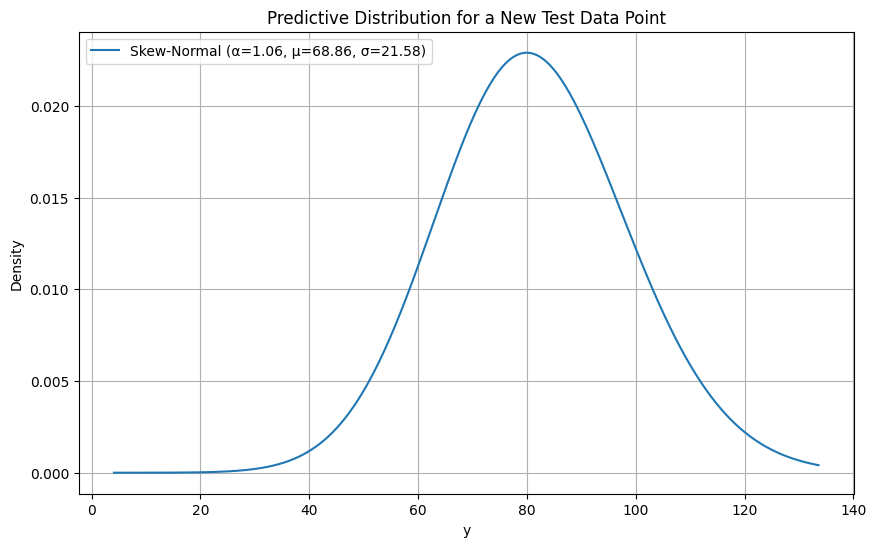

In [19]:
# 6. Build Predictive Distribution for a New Data Point from the Test Set
# -----------------------------
# For demonstration, we'll take the first test data point.
X_new = X_test_std[0, :]
mu_new = X_new @ w_optimal
dist_new = skewnorm(a=alpha_optimal, loc=mu_new, scale=sigma_optimal)

y_values = np.linspace(mu_new - 3 * sigma_optimal, mu_new +3 * sigma_optimal, 1000)
pdf_values = dist_new.pdf(y_values)

plt.figure(figsize=(10, 6))
plt.plot(y_values, pdf_values,
         label=f'Skew-Normal (α={alpha_optimal:.2f}, μ={mu_new:.2f}, σ={sigma_optimal:.2f})')
plt.xlabel('y')
plt.ylabel('Density')
plt.title('Predictive Distribution for a New Test Data Point')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
N_q = 50
N_h = 12
# standardized features for future time steps
X_future_std = X_test_std[-N_h:, :]

mu = X_future_std @ w_optimal   # predicted mean
sigma = np.full_like(mu, sigma_optimal) # constant std
alpha = np.full_like(mu, alpha_optimal)  # constant skewness

In [21]:
from pyomo.opt import SolverFactory

storage_capacity = 1000
initial_storage = 0
penalty_factor = 10

# Learned parameters
mu = [0.50, 0.48, 0.46, 0.45, 0.43, 0.41, 0.39, 0.37, 0.35, 0.34, 0.32, 0.30]
sigma = [6.0] * N_h
alpha = [1.5] * N_h

# Generate quantiles and match probabilities
def generate_quantiles_and_match_probs(mu, sigma, alpha, N_q=50):
    dist = skewnorm(a=alpha, loc=mu, scale=sigma)
    p = np.array([(q + 1) / (N_q + 2) for q in range(N_q)])
    quantiles = dist.ppf(p)
    match_probs_buy = p
    match_probs_sell = 1 - p
    return quantiles, match_probs_buy, match_probs_sell

quantiles_all = [[], []]  # [buy, sell]
match_probs_all = [[], []]

for t in range(N_h):
    q, p_buy, p_sell = generate_quantiles_and_match_probs(mu[t], sigma[t], alpha[t], N_q)

    # Debug : vérifier que les quantiles varient d'une heure à l'autre
    print(f"Hour {t+1:02d} | mu={mu[t]:.2f} | q[25]={q[25]:.2f} | q[0]={q[0]:.2f} | q[-1]={q[-1]:.2f}")

    quantiles_all[0].append(q)
    quantiles_all[1].append(q)
    match_probs_all[0].append(p_buy)
    match_probs_all[1].append(p_sell)
# Convert to dictionaries for Pyomo
quantile_dict = {(s+1, t+1, q+1): quantiles_all[s][t][q]
                 for s in range(2) for t in range(N_h) for q in range(N_q)}
match_prob_dict = {(s+1, t+1, q+1): match_probs_all[s][t][q]
                   for s in range(2) for t in range(N_h) for q in range(N_q)}

# Pyomo model
model = po.ConcreteModel()
model.S = po.Set(initialize=[1, 2])
model.T = po.RangeSet(1, N_h)
model.Q = po.RangeSet(1, N_q)

model.quantiles = po.Param(model.S, model.T, model.Q, initialize=quantile_dict)
model.match_probs = po.Param(model.S, model.T, model.Q, initialize=match_prob_dict)

model.volumes = po.Var(model.S, model.T, model.Q, domain=po.NonNegativeReals, bounds=(0, 1000))
model.storage = po.Var(model.T, domain=po.NonNegativeReals, initialize=initial_storage)
model.traded = po.Var(model.T, domain=po.Reals)
model.profit = po.Var(model.T, bounds=(-1e6, 1e6))
model.income = po.Var(model.T, bounds=(0, 1e6))
model.expense = po.Var(model.T, bounds=(0, 1e6))
model.discharge = po.Var(model.T, bounds=(0, storage_capacity))
model.charge = po.Var(model.T, bounds=(0, storage_capacity))
# Constraints
def volume_balance_rule(m, t):
    buy = sum(m.volumes[1, t, q] * m.match_probs[1, t, q] for q in m.Q)
    sell = sum(m.volumes[2, t, q] * m.match_probs[2, t, q] for q in m.Q)
    return buy == m.traded[t] + sell
model.volume_balance = po.Constraint(model.T, rule=volume_balance_rule)

def storage_balance(m, t):
    if t == 1:
        return m.storage[t] == initial_storage + m.traded[t] - m.discharge[t]
    return m.storage[t] == m.storage[t-1] + m.traded[t] - m.discharge[t]
model.storage_update = po.Constraint(model.T, rule=storage_balance)


def storage_limit_rule(m, t):
    return m.storage[t] <= storage_capacity
model.storage_limit = po.Constraint(model.T, rule=storage_limit_rule)

def sell_equals_discharge(m, t):
    sold = sum(m.volumes[2, t, q] * m.match_probs[2, t, q] for q in m.Q)
    return sold == m.discharge[t]
model.sell_link = po.Constraint(model.T, rule=sell_equals_discharge)

def buy_equals_charge(m, t):
    bought = sum(m.volumes[1, t, q] * m.match_probs[1, t, q] for q in m.Q)
    return bought == m.charge[t]
model.buy_link = po.Constraint(model.T, rule=buy_equals_charge)

def income_rule(m, t):
    return m.income[t] == sum(m.volumes[2, t, q] * m.match_probs[2, t, q] * m.quantiles[2, t, q] for q in m.Q)
model.income_calc = po.Constraint(model.T, rule=income_rule)

def expense_rule(m, t):
    return m.expense[t] == sum(m.volumes[1, t, q] * m.match_probs[1, t, q] * m.quantiles[1, t, q] for q in m.Q)
model.expense_calc = po.Constraint(model.T, rule=expense_rule)

def profit_rule(m, t):
    return m.profit[t] == m.income[t] - m.expense[t]
model.profit_calc = po.Constraint(model.T, rule=profit_rule)

# Restrict discharge to available storage
def discharge_limit(m, t):
    return m.discharge[t] <= m.storage[t]
model.discharge_cap = po.Constraint(model.T, rule=discharge_limit)


# Objective
def objective_rule(m):
    return sum(m.profit[t] for t in m.T)
model.objective = po.Objective(rule=objective_rule, sense=po.maximize)

solver = SolverFactory("glpk", executable=r"C:\Users\Oulmekki\Desktop\glpk-4.65\w64\glpsol.exe")
results = solver.solve(model, tee=True)

Hour 01 | mu=0.50 | q[25]=4.25 | q[0]=-4.09 | q[-1]=12.92
Hour 02 | mu=0.48 | q[25]=4.23 | q[0]=-4.11 | q[-1]=12.90
Hour 03 | mu=0.46 | q[25]=4.21 | q[0]=-4.13 | q[-1]=12.88
Hour 04 | mu=0.45 | q[25]=4.20 | q[0]=-4.14 | q[-1]=12.87
Hour 05 | mu=0.43 | q[25]=4.18 | q[0]=-4.16 | q[-1]=12.85
Hour 06 | mu=0.41 | q[25]=4.16 | q[0]=-4.18 | q[-1]=12.83
Hour 07 | mu=0.39 | q[25]=4.14 | q[0]=-4.20 | q[-1]=12.81
Hour 08 | mu=0.37 | q[25]=4.12 | q[0]=-4.22 | q[-1]=12.79
Hour 09 | mu=0.35 | q[25]=4.10 | q[0]=-4.24 | q[-1]=12.77
Hour 10 | mu=0.34 | q[25]=4.09 | q[0]=-4.25 | q[-1]=12.76
Hour 11 | mu=0.32 | q[25]=4.07 | q[0]=-4.27 | q[-1]=12.74
Hour 12 | mu=0.30 | q[25]=4.05 | q[0]=-4.29 | q[-1]=12.72
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\Oulmekki\AppData\Local\Temp\tmpubwcvcu7.glpk.raw --wglp
 C:\Users\Oulmekki\AppData\Local\Temp\tmpp2gkiblm.glpk.glp --cpxlp C:\Users\Oulmekki\AppData\Local\Temp\tmpiflqlnli.pyomo.lp
Reading problem data from '

In [22]:
print("\n--- Storage and Profit ---")
for t in model.T:
    print(f"Hour {t:2d} | Storage: {po.value(model.storage[t]):8.2f} | Profit: {po.value(model.profit[t]):8.2f}")


--- Storage and Profit ---
Hour  1 | Storage:   333.33 | Profit:  3681.59
Hour  2 | Storage:   444.44 | Profit:  4748.55
Hour  3 | Storage:   481.48 | Profit:  5088.70
Hour  4 | Storage:   493.83 | Profit:  5200.11
Hour  5 | Storage:   497.94 | Profit:  5228.89
Hour  6 | Storage:   499.31 | Profit:  5231.79
Hour  7 | Storage:   499.77 | Profit:  5226.08
Hour  8 | Storage:   499.92 | Profit:  5217.51
Hour  9 | Storage:   499.97 | Profit:  5207.99
Hour 10 | Storage:   499.99 | Profit:  5203.14
Hour 11 | Storage:   500.00 | Profit:  5193.20
Hour 12 | Storage:   500.00 | Profit:  5183.21


In [23]:
N_s = 5               # number of scenarios
storage_capacity = 1000
initial_storage = 0

mu = [0.50 - 0.02 * t for t in range(N_h)]
sigma = [6.0] * N_h
alpha = [1.5] * N_h

# --- Scenario generation ---
p = np.array([(q + 1) / (N_q + 2) for q in range(N_q)])
rng = np.random.default_rng(seed=42)

quantiles = {}
match_probs = {}
for s in range(1, N_s+1):
    for t in range(1, N_h+1):
        mu_s = mu[t-1] + rng.normal(0, 0.1)
        sigma_s = sigma[t-1] * rng.uniform(0.9, 1.1)
        alpha_s = alpha[t-1] + rng.uniform(-0.5, 0.5)
        dist = skewnorm(a=alpha_s, loc=mu_s, scale=sigma_s)
        q_vals = dist.ppf(p)
        for q in range(1, N_q+1):
            for s_id in [1, 2]:  # 1 = buy, 2 = sell
                quantiles[(s, s_id, t, q)] = q_vals[q-1]
                match_probs[(s, s_id, t, q)] = p[q-1] if s_id == 1 else 1 - p[q-1]

p_s = {s: 1/N_s for s in range(1, N_s+1)}

# --- Model ---
model = po.ConcreteModel()
model.S = po.RangeSet(1, N_s)
model.T = po.RangeSet(1, N_h)
model.Q = po.RangeSet(1, N_q)
model.Side = po.Set(initialize=[1, 2])  # 1 = buy, 2 = sell

model.quantiles = po.Param(model.S, model.Side, model.T, model.Q, initialize=quantiles)
model.match_probs = po.Param(model.S, model.Side, model.T, model.Q, initialize=match_probs)
model.p_s = po.Param(model.S, initialize=p_s)

# --- Variables ---
model.volumes = po.Var(model.S, model.Side, model.T, model.Q, domain=po.NonNegativeReals, bounds=(0, 10000))
model.charge = po.Var(model.S, model.T, domain=po.NonNegativeReals)
model.discharge = po.Var(model.S, model.T, domain=po.NonNegativeReals)
model.storage = po.Var(model.S, model.T, domain=po.NonNegativeReals)
model.income = po.Var(model.S, model.T, bounds=(0, 1e6))
model.expense = po.Var(model.S, model.T, bounds=(0, 1e6))
model.profit = po.Var(model.S, model.T, bounds=(-1e6, 1e6))

# --- Constraints ---
def storage_balance(m, s, t):
    if t == 1:
        return m.storage[s, t] == initial_storage + m.charge[s, t] - m.discharge[s, t]
    return m.storage[s, t] == m.storage[s, t-1] + m.charge[s, t] - m.discharge[s, t]
model.storage_balance = po.Constraint(model.S, model.T, rule=storage_balance)

def storage_limit(m, s, t):
    return m.storage[s, t] <= storage_capacity
model.storage_limit = po.Constraint(model.S, model.T, rule=storage_limit)

def income_rule(m, s, t):
    return m.income[s, t] == sum(m.volumes[s, 2, t, q] * m.match_probs[s, 2, t, q] * m.quantiles[s, 2, t, q] for q in m.Q)
model.income_calc = po.Constraint(model.S, model.T, rule=income_rule)

def expense_rule(m, s, t):
    return m.expense[s, t] == sum(m.volumes[s, 1, t, q] * m.match_probs[s, 1, t, q] * m.quantiles[s, 1, t, q] for q in m.Q)
model.expense_calc = po.Constraint(model.S, model.T, rule=expense_rule)

def profit_rule(m, s, t):
    return m.profit[s, t] == m.income[s, t] - m.expense[s, t]
model.profit_calc = po.Constraint(model.S, model.T, rule=profit_rule)

def buy_equals_charge(m, s, t):
    return sum(m.volumes[s, 1, t, q] * m.match_probs[s, 1, t, q] for q in m.Q) == m.charge[s, t]
model.buy_link = po.Constraint(model.S, model.T, rule=buy_equals_charge)

def sell_equals_discharge(m, s, t):
    return sum(m.volumes[s, 2, t, q] * m.match_probs[s, 2, t, q] for q in m.Q) == m.discharge[s, t]
model.sell_link = po.Constraint(model.S, model.T, rule=sell_equals_discharge)

# --- Non-anticipativity (multistage part) ---
def nonanticip_volumes(m, s, side, q):
    if s == 1:
        return po.Constraint.Skip
    return m.volumes[s, side, 1, q] == m.volumes[1, side, 1, q]
model.nonanticip_vol = po.Constraint(model.S, model.Side, model.Q, rule=nonanticip_volumes)

def nonanticip_charge(m, s):
    if s == 1:
        return po.Constraint.Skip
    return m.charge[s, 1] == m.charge[1, 1]
model.nonanticip_c = po.Constraint(model.S, rule=nonanticip_charge)

def nonanticip_discharge(m, s):
    if s == 1:
        return po.Constraint.Skip
    return m.discharge[s, 1] == m.discharge[1, 1]
model.nonanticip_d = po.Constraint(model.S, rule=nonanticip_discharge)

# --- Objective ---
def objective_rule(m):
    return sum(m.p_s[s] * sum(m.profit[s, t] for t in m.T) for s in m.S)
model.objective = po.Objective(rule=objective_rule, sense=po.maximize)

solver = po.SolverFactory("glpk", executable=r"C:\Users\Oulmekki\Desktop\glpk-4.65\w64\glpsol.exe")
results = solver.solve(model, tee=True)
results.write()
print("Solver status :", results.solver.status)
print("Termination condition :", results.solver.termination_condition)
# --- Output ---
print("\n--- Expected Profit by Hour ---")
for t in model.T:
    avg_profit = sum(po.value(model.p_s[s] * model.profit[s, t]) for s in model.S)
    print(f"Hour {t:2d} | Expected Profit: {avg_profit:.2f}")

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\Oulmekki\AppData\Local\Temp\tmp6dmoop1h.glpk.raw --wglp
 C:\Users\Oulmekki\AppData\Local\Temp\tmpfvuyyxb1.glpk.glp --cpxlp C:\Users\Oulmekki\AppData\Local\Temp\tmphkajqxj9.pyomo.lp
Reading problem data from 'C:\Users\Oulmekki\AppData\Local\Temp\tmphkajqxj9.pyomo.lp'...
828 rows, 6360 columns, 13531 non-zeros
22444 lines were read
Writing problem data to 'C:\Users\Oulmekki\AppData\Local\Temp\tmpfvuyyxb1.glpk.glp'...
27022 lines were written
GLPK Simplex Optimizer, v4.65
828 rows, 6360 columns, 13531 non-zeros
Preprocessing...
708 rows, 6175 columns, 13166 non-zeros
Scaling...
 A: min|aij| =  1.651e-03  max|aij| =  1.355e+01  ratio =  8.206e+03
GM: min|aij| =  1.603e-01  max|aij| =  6.237e+00  ratio =  3.890e+01
EQ: min|aij| =  2.571e-02  max|aij| =  1.000e+00  ratio =  3.890e+01
Constructing initial basis...
Size of triangular part is 700
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (27

In [24]:
from pyomo.environ import value

data = []
for s in model.S:
    for t in model.T:
        data.append({
            "Scenario": s,
            "Hour": t,
            "Profit": value(model.profit[s, t]),
            "Storage": value(model.storage[s, t]),
            "Charge": value(model.charge[s, t]),
            "Discharge": value(model.discharge[s, t])
        })

df = pd.DataFrame(data)


In [25]:
print(df.head())  

   Scenario  Hour         Profit  Storage        Charge     Discharge
0         1     1  245561.668521   1000.0  63307.692308  62307.692308
1         1     2  233431.589012      0.0  62500.000000  63500.000000
2         1     3  300310.041519   1000.0  63307.692308  62307.692308
3         1     4  244438.007557   1000.0  62500.000000  62500.000000
4         1     5  291536.436275      0.0  62500.000000  63500.000000


In [33]:
print(f"\n{'Hour':^4} | {'Med. Price':^12} | {'Buy Vol':^10} | {'Sell Vol':^10} | {'Spent':^10} | {'Earned':^10} || {'Profit':^10} || {'Cum. Profit':^14}")
print("-" * 110)

cum_profit = 0.0
q_mid = (N_q + 1) // 2  # quantile médian

for t in model.T:
    t_ = po.value(t)

    # Prix médian (side=2 = vente)
    median_price = np.mean([
        po.value(model.quantiles[s, 2, t_, q_mid])
        for s in model.S
    ])

    # Volume acheté total
    buy_vol = sum([
        po.value(model.p_s[s]) * sum(
            po.value(model.volumes[s, 1, t_, q]) * po.value(model.match_probs[s, 1, t_, q])
            for q in model.Q
        )
        for s in model.S
    ])

    # Volume vendu total
    sell_vol = sum([
        po.value(model.p_s[s]) * sum(
            po.value(model.volumes[s, 2, t_, q]) * po.value(model.match_probs[s, 2, t_, q])
            for q in model.Q
        )
        for s in model.S
    ])

    # Dépenses, revenus et profits
    spent = sum(po.value(model.p_s[s]) * po.value(model.expense[s, t_]) for s in model.S)
    earned = sum(po.value(model.p_s[s]) * po.value(model.income[s, t_]) for s in model.S)
    profit = earned - spent
    cum_profit += profit

    print(f"{t_:^4} | {median_price:^12.2f} | {buy_vol:^10.2f} | {sell_vol:^10.2f} | "
          f"{spent:^10.2f} | {earned:^10.2f} || {profit:^10.2f} || {cum_profit:^14.2f}")



Hour |  Med. Price  |  Buy Vol   |  Sell Vol  |   Spent    |   Earned   ||   Profit   ||  Cum. Profit  
--------------------------------------------------------------------------------------------------------------
 1   |     3.80     |  63307.69  |  62307.69  | 122605.87  | 390768.57  || 268162.71  ||   268162.71   
 2   |     3.88     |  62500.00  |  62900.00  | 132998.43  | 389552.91  || 256554.48  ||   524717.18   
 3   |     4.07     |  62661.54  |  63061.54  | 133396.68  | 416855.39  || 283458.71  ||   808175.89   
 4   |     3.84     |  62661.54  |  62461.54  | 127191.93  | 389771.57  || 262579.64  ||   1070755.53  
 5   |     3.90     |  62823.08  |  62823.08  | 127628.77  | 398653.74  || 271024.97  ||   1341780.51  
 6   |     3.83     |  62661.54  |  62661.54  | 121234.56  | 394771.17  || 273536.61  ||   1615317.12  
 7   |     3.88     |  62823.08  |  62623.08  | 124628.70  | 398552.93  || 273924.24  ||   1889241.35  
 8   |     3.80     |  62661.54  |  62861.54  | 124396.4